### 单张深度图片读取以及转换成法向量图
读入的是uint8的3通道rgb图片，是已经编码好的深度图，需要解码以获取真实深度
carla 使用的转换方式是如下公式
normalized = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)
in_meters = 1000 * normalized
kitti 是直接将图片读入，然后/65535得到归一化的数值用于训练

plt,cv2 都支持0-1之间的normalized图片直接show。单通道的depth图片经过计算成法向量后用plt可以直接show出，但是用cv2show出的话需要在cvtColor一下



注：plt.imshow(n_vis_norm) 和 plt.show() 是两个分别用于绘制图像和显示图像的函数，它们的功能是不同的。

plt.imshow(n_vis_norm) 是用来将数据绘制成图像的，但此时图像并没有被实际显示出来。只有在调用 plt.show() 之后，图像才会在一个新窗口中显示出来。因此，它们不是多余的，而是各自执行了不同的任务。

但如果你是在Jupyter notebook环境中运行代码，那么通常你可以只用 plt.imshow(n_vis_norm)，不需要 plt.show()，因为在Jupyter notebook中，每个cell的最后一个表达式的结果会自动显示出来。但是在一般的Python环境中，你需要显式调用 plt.show() 来显示图像。


### 单张深度转normal示例

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *


def depth2normal(depth_data, cam_fx, cam_fy, u0, v0):
    # 读取图片高宽
    h, w = (720, 1280)

    u_map = np.ones((h, 1)) * np.arange(1, w + 1) - u0  # u-u0
    v_map = np.arange(1, h + 1).reshape(h, 1) * np.ones((1, w)) - v0  # v-v0
    # get depth gradients
    Gu, Gv = get_DAG_filter(depth_data)
    # Depth to Normal Translation
    est_nx = Gu * cam_fx
    est_ny = Gv * cam_fy
    est_nz = -(depth_data + v_map * Gv + u_map * Gu)
    est_normal = cv2.merge((est_nx, est_ny, est_nz))
    # vector normalization
    est_normal = vector_normalization(est_normal)
    # MRF-based Normal Refinement
    est_normal = MRF_optim(depth_data, est_normal) # est_normal.dtype float64
    # translate interval from [-1,1] to [0,1]
    n_vis = (1 - est_normal) / 2

    return n_vis


depth_data = cv2.imread('/media/ljh/data/carla_v2/2023_05_16/Tiled_V2/ClearNight/roll0/base05/depth_left/22_49102915.png')
scales = np.array([65536.0, 256.0, 1.0])/(256**3 -1)*1000
dep_l = np.dot(depth_data, scales).astype(np.float32)  #  获取真实深度3通道float32的图
# print(np.max(dep_l)) # 9.581626
# print(np.min(dep_l)) # 1.8695594
cam_fx, cam_fy, u0, v0 = get_cam_params('/home/ljh/Desktop/Workspace/depth-to-normal-translator/figs/params.txt')
# 真实深度转换为normal
n_vis = depth2normal(dep_l, cam_fx, cam_fy, u0, v0)
# fig, axes = plt.subplots(1, 1, figsize=(12, 8))

n_vis_norm = n_vis
# print('n_vis_norm.dtype', n_vis_norm.dtype)
# print('n_vis_norm.min', np.min(n_vis_norm))
# print('n_vis_norm.max', np.max(n_vis_norm))
n_vis_255 = np.round(n_vis_norm * 255).astype(np.uint8)
n_vis_65535 = np.round(n_vis_norm * 65535).astype(np.uint16)
n_vis_rgb_65535 = cv2.cvtColor(n_vis_65535, cv2.COLOR_BGR2RGB)
# print('n_vis_255.max:', np.max(n_vis_255))
# print('n_vis_255.min:', np.min(n_vis_255))
# print('n_vis_65535.max:', np.max(n_vis_65535))
# print('n_vis_65535.min:', np.min(n_vis_65535))
n_vis_rgb_norm = cv2.cvtColor(n_vis_norm.astype(np.float32), cv2.COLOR_BGR2RGB)
n_vis_rgb_255 = cv2.cvtColor(n_vis_255, cv2.COLOR_BGR2RGB)
# plt.figure(f'error map')
# fig = plt.imshow(n_vis_norm)
# plt.show()
# plt.close(fig)
# cv2.imshow('n_vis_norm', n_vis_norm)
# cv2.imshow('n_vis_255', n_vis_255)
cv2.imshow('n_vis_rgb_norm', n_vis_rgb_norm)
cv2.imshow('n_vis_rgb_255', n_vis_rgb_255)
cv2.imshow('n_vis_rgb_65535', n_vis_rgb_65535)


cv2.waitKey(0)
cv2.destroyAllWindows()

## 检查数据集结构以及样本数量

In [1]:
import os

def count_gt_images(folder_path):
    gt_count = 0
    for file in os.listdir(folder_path):
        if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.npy'):
            gt_count += 1
    return gt_count

def analyze_dataset(folder_path, level=0):
    subfolders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    total_gt_images = 0

    if not subfolders:
        if os.path.basename(folder_path) == 'left_normal_png':
            gt_count = count_gt_images(folder_path)
            total_gt_images += gt_count
            print(f"{'  ' * level} └─ {os.path.basename(folder_path)}: {gt_count} 个 rgb 图片")
    else:
        print(f"{'  ' * level} └─ {os.path.basename(folder_path)}")
        for subfolder in subfolders:
            subfolder_path = os.path.join(folder_path, subfolder)
            total_gt_images += analyze_dataset(subfolder_path, level + 1)

    return total_gt_images

dataset_folder_path = '/media/ljh/data/cityscapes/left_normal_png'
total_gt_images = analyze_dataset(dataset_folder_path)
print(f"\n所有子文件夹共有 {total_gt_images} 个 rgb 图片")


 └─ left_normal_png
   └─ test
   └─ train
   └─ val

所有子文件夹共有 0 个 rgb 图片


### 检查是否有样本缺失，重复

In [ ]:
import os

# Path to the original dataset
original_dataset_path = '/media/ljh/data/carla_v2'

# Iterate over the original dataset
for root, dirs, files in os.walk(original_dataset_path):
    if 'base05' in root:
        print(f"Checking {root}")
        # Initialize a dictionary to store file counts for each modality in the current base05 directory
        file_counts = {}

        # Iterate over the subdirectories (modalities) in the current base05 directory
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            if os.path.isdir(subdir_path):
                file_count = len(os.listdir(subdir_path))  # Get number of files in the subdir
                file_counts[subdir] = file_count

        # Check if all counts are equal
        counts = list(file_counts.values())
        if counts.count(counts[0]) == len(counts):
            print(f"All modalities in {root} have equal number of files.")
        else:
            print(f"Not all modalities in {root} have equal number of files.")

        # Print the exact counts for each modality
        for modality, count in file_counts.items():
            print(f"Modality: {modality}, Count: {count}")


## 数据集批量depth2normal 输入数据集路径即可

In [2]:
import os
import numpy as np
import cv2
from utils import *


def depth2normal(depth_data, cam_fx, cam_fy, u0, v0):
    h, w = (720, 1280)

    u_map = np.ones((h, 1)) * np.arange(1, w + 1) - u0
    v_map = np.arange(1, h + 1).reshape(h, 1) * np.ones((1, w)) - v0
    Gu, Gv = get_DAG_filter(depth_data)
    est_nx = Gu * cam_fx
    est_ny = Gv * cam_fy
    est_nz = -(depth_data + v_map * Gv + u_map * Gu)
    est_normal = cv2.merge((est_nx, est_ny, est_nz))
    est_normal = vector_normalization(est_normal)
    est_normal = MRF_optim(depth_data, est_normal)
    n_vis = (1 - est_normal) / 2

    return n_vis

# 递归遍历文件夹
def process_folder(root_folder):

    cam_fx, cam_fy, u0, v0 = get_cam_params('/home/ljh/Desktop/Workspace/depth-to-normal-translator/figs/params.txt')
    scales = np.array([65536.0, 256.0, 1.0])/(256**3 -1)*1000
    for root, dirs, files in os.walk(root_folder):
        if 'depth_left' in root:
            print("Processing files in: " + root)
            for file_name in files:
                if file_name.endswith('.png'):
                    # 读取深度图
                    depth_file_path = os.path.join(root, file_name)
                    depth_data = cv2.imread(depth_file_path)
                    # 计算真实深度
                    dep_l = np.dot(depth_data, scales).astype(np.float32)
                    print(dep_l.shape, dep_l.dtype, np.min(dep_l), np.max(dep_l))
                    # 转换为法向量
                    n_vis = depth2normal(dep_l, cam_fx, cam_fy, u0, v0)
                    # 转换为uint16
                    n_vis_65535 = np.round(n_vis * 65535).astype(np.uint16)
                    # 保存为png
                    output_file_path = depth_file_path.replace('depth_left', 'test_sne')
                    output_dir = os.path.dirname(output_file_path)
                    os.makedirs(output_dir, exist_ok=True)
                    cv2.imwrite(output_file_path, n_vis_65535)
                    print("Processed files: " + depth_file_path)
root_folder = '/media/ljh/data/carla_v2/training/Wetroad1/ClearNight/roll0/base05'  # 设置数据集根目录路径
process_folder(root_folder)
print('all finished!')

Processing files in: /media/ljh/data/carla_v2/training/Wetroad1/ClearNight/roll0/base05/depth_left
(720, 1280) float32 1.8823148 999.9997
Processed files: /media/ljh/data/carla_v2/training/Wetroad1/ClearNight/roll0/base05/depth_left/1068_749841502.png
(720, 1280) float32 1.8801094 999.9997
Processed files: /media/ljh/data/carla_v2/training/Wetroad1/ClearNight/roll0/base05/depth_left/1071_449841543.png
(720, 1280) float32 1.8668772 999.9997
Processed files: /media/ljh/data/carla_v2/training/Wetroad1/ClearNight/roll0/base05/depth_left/1072_749841562.png
(720, 1280) float32 1.8703939 999.9997
Processed files: /media/ljh/data/carla_v2/training/Wetroad1/ClearNight/roll0/base05/depth_left/1072_99841552.png
(720, 1280) float32 1.8711687 999.9997
Processed files: /media/ljh/data/carla_v2/training/Wetroad1/ClearNight/roll0/base05/depth_left/1073_399841572.png
(720, 1280) float32 1.8883349 999.9997
Processed files: /media/ljh/data/carla_v2/training/Wetroad1/ClearNight/roll0/base05/depth_left/107

KeyboardInterrupt: 

## 因为只需要左图，depth，normal，gt，disp，其余的不需要，通过脚本批量删除，节省空间

In [2]:
import os

def delete_processed_data(data_dir, dir_names):
    count = 0
    for root, dirs, files in os.walk(data_dir):
        if any(dir_name in root for dir_name in dir_names):  # 如果root包含任何在dir_names的目录名
            for file in files:
                if file.endswith('_color.png') or file.endswith('_instanceIds.png'):
                    file_path = os.path.join(root, file)
                    os.remove(file_path)  # 删除.npy文件
                    count += 1
            if not os.listdir(root):  # 如果目录是空的
                os.rmdir(root)  # 删除空目录
    print('count:', count)
data_dir = '/media/ljh/data/Cityscapes'  # 将此路径更改为你的数据集路径
dir_names = ['annotations']  # 将此列表更改为你要删除的目录名列表
delete_processed_data(data_dir, dir_names)
print('all finished!')


count: 10000
all finished!


### 重命名文件夹

In [ ]:
import os

# Path to the original dataset
original_dataset_path = '/media/ljh/data/carla_v2'
count = 0
# Iterate over the original dataset
for root, dirs, _ in os.walk(original_dataset_path):
    if 'tdisp_left' in dirs:
        old_dir = os.path.join(root, 'tdisp_left')
        new_dir = os.path.join(root, 'tdisp')
        os.rename(old_dir, new_dir)
        print(f"Renamed directory from {old_dir} to {new_dir}")
        count += 1

print(count)

### 恢复误删除的文件

In [ ]:
import os
import shutil

# Paths to the original and backup datasets
original_dataset_path = '/media/ljh/data/carla_v2'
backup_dataset_path = '/media/ljh/data/carla_backup/carla_v2'

# Step 1: Iterate over original dataset and record the appropriate paths for 'disparity_left' files
disparity_target_paths = {}
for root, dirs, files in os.walk(original_dataset_path):
    for file in files:
        # Extract the sample name from each file (excluding the extension)
        sample_name = os.path.splitext(file)[0]
        # Construct the path to where the 'disparity_left' file should be in the original dataset
        target_path = os.path.join(os.path.dirname(root), 'disparity_left', f'{sample_name}.npy')
        disparity_target_paths[sample_name] = target_path

# Step 2: Iterate over backup dataset, find 'disparity_left' .npy files and copy them to the corresponding path in original dataset
for root, dirs, files in os.walk(backup_dataset_path):
    if 'disparity_left' in root:
        for file in files:
            if file.endswith('.npy'):
                # Extract the sample name from each file (excluding the extension)
                sample_name = os.path.splitext(file)[0]
                if sample_name in disparity_target_paths:
                    # Create folders in the original dataset if they do not already exist
                    os.makedirs(os.path.dirname(disparity_target_paths[sample_name]), exist_ok=True)
                    # Copy the .npy file from the backup dataset to the original dataset
                    shutil.copy2(os.path.join(root, file), disparity_target_paths[sample_name])
                    print(f'moved {sample_name} to  {disparity_target_paths[sample_name]}')
print('all finished!')

## 检查gt格式是否有误

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取语义分割图像
seg_image_file = '/media/ljh/data/carla_v2/2023_05_16/Tiled_V2/ClearNight/roll0/base05/semantic_segmentation_left/23_349102934.png'
seg_image = cv2.imread(seg_image_file)
print(seg_image.shape)
# 转换为RGB格式
seg_image_rgb = cv2.cvtColor(seg_image, cv2.COLOR_BGR2RGB)
# seg_image_rgb = seg_image
fig, axes = plt.subplots(1, 1, figsize=(9, 6))

axes.imshow(seg_image_rgb)  # 如果是彩色图像，删除 'cmap' 参数
axes.set_title('gt Image')
axes.axis('off')

# 显示图像
plt.show()
# # 获取所有独特颜色
unique_colors = np.unique(seg_image_rgb.reshape(-1, seg_image_rgb.shape[2]), axis=0)
print(unique_colors.shape)
# 输出独特颜色
print("Unique labels (RGB):")
for color in unique_colors:
    print(color)

## 经过检查 没有任何问题，接下来将gt转成3分类

In [ ]:
import os
from PIL import Image
import numpy as np

root_path = '/media/ljh/data/carla_v2'  # Update this to your dataset path.

# Define the RGB values for the categories.
road_rgb = np.array([128, 64, 128])
pothole_rgb = np.array([0, 255, 0])
roadline_rgb = np.array([157, 234, 50])

# Walk through the directory tree.
for root, dirs, files in os.walk(root_path):
    # Only proceed if we're in a semantic_segmentation_left directory.
    if os.path.basename(root) == 'semantic_segmentation_left':
        # Get the path of the new directory.
        new_dir_path = os.path.join(os.path.dirname(root), 'gt_seg')
        os.makedirs(new_dir_path, exist_ok=True)

        # Iterate over each file.
        for file in files:
            # Ensure we're working with PNG files.
            if file.endswith('.png'):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                data = np.array(img)

                # Update the pixels for the 'roadline' category to the 'road' category.
                data[(data==roadline_rgb).all(axis=-1)] = road_rgb

                # Update the pixels for all other categories to [0, 0, 0].
                mask = np.zeros(data.shape[:2], np.bool)
                mask[(data==road_rgb).all(axis=-1)] = True
                mask[(data==pothole_rgb).all(axis=-1)] = True
                data[~mask] = [0, 0, 0]

                # Save the updated image.
                img = Image.fromarray(data)
                img.save(os.path.join(new_dir_path, file))
                print(f'processed {file}')
print('all finished!')

## disparity转tdisp代码
#### 注，seg_gt = Image.open(seg_gt_path).convert('L')这里面rgb转灰度图公式是：L = R * 299/1000 + G * 587/1000 + B * 114/1000
其中3类别计算结果：pothole=150 road=90 sidewalk=120

In [ ]:
import math
import os
import sys
import numpy as np
import tifffile
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
from pathlib import Path

plt.ion()


def pt_param_estimation(disp, mask):
    height, width = disp.shape
    length = width * height
    umap = (np.ones((height, 1)) * np.arange(1, width +
            1).reshape(1, width)).astype(np.float64)
    vmap = (np.arange(1, height + 1).reshape(height, 1)
            * np.ones((1, width))).astype(np.float64)
    u_1d = umap.reshape(length, 1)
    v_1d = vmap.reshape(length, 1)
    # if images have the same shape, the above lines can be moved outside.

    d_1d = disp.reshape(length, 1)
    m_1d = mask.reshape(length, 1)
    d_1d = np.delete(d_1d, np.where(m_1d == 1), 0)
    u_1d = np.delete(u_1d, np.where(m_1d == 1), 0)
    v_1d = np.delete(v_1d, np.where(m_1d == 1), 0)
    m_1d = np.delete(m_1d, np.where(m_1d == 1), 0)
    # axis arg (0) should be considered to keep the vector shape.

    su = np.sum(u_1d)
    sv = np.sum(v_1d)
    sd = np.sum(d_1d)
    su2 = np.sum(np.square(u_1d))
    sv2 = np.sum(np.square(v_1d))
    suv = np.sum(u_1d * v_1d)
    sdu = np.sum(d_1d * u_1d)
    sdv = np.sum(d_1d * v_1d)

    n = len(d_1d)

    beta0 = (sd ** 2 * (sv2 + su2) - 2 * sd *
             (sv * sdv + su * sdu) + n * (sdv ** 2 + sdu ** 2)) / 2
    beta1 = (sd ** 2 * (sv2 - su2) + 2 * sd *
             (su * sdu - sv * sdv) + n * (sdv ** 2 - sdu ** 2)) / 2
    beta2 = -sd ** 2 * suv + sd * (sv * sdu + su * sdv) - n * sdv * sdu
    gamma0 = (n * sv2 + n * su2 - sv ** 2 - su ** 2) / 2
    gamma1 = (n * sv2 - n * su2 - sv ** 2 + su ** 2) / 2
    gamma2 = sv * su - n * suv

    del su, sv, sd, su2, sv2, suv, sdu, sdv, n

    A = (beta1 * gamma0 - beta0 * gamma1)
    B = (beta0 * gamma2 - beta2 * gamma0)
    C = (beta1 * gamma2 - beta2 * gamma1)

    delta = A ** 2 + B ** 2 - C ** 2
    theta1 = math.atan((A + math.sqrt(delta)) / (B - C))
    theta2 = math.atan((A - math.sqrt(delta)) / (B - C))

    del A, B, C, beta0, beta1, beta2, gamma0, gamma1, gamma2, delta

    t1_1d = v_1d * math.cos(theta1) - u_1d * math.sin(theta1)
    t2_1d = v_1d * math.cos(theta2) - u_1d * math.sin(theta2)

    o_1d = np.ones((len(t1_1d), 1)).astype(np.float64)

    T1 = np.concatenate((o_1d, t1_1d), axis=1)
    T2 = np.concatenate((o_1d, t2_1d), axis=1)

    del t1_1d, t2_1d

    f1 = np.dot(np.dot(np.dot(np.transpose(d_1d), T1), np.linalg.inv(np.dot(np.transpose(T1), T1))),
                np.dot(np.transpose(T1), d_1d))
    f2 = np.dot(np.dot(np.dot(np.transpose(d_1d), T2), np.linalg.inv(np.dot(np.transpose(T2), T2))),
                np.dot(np.transpose(T2), d_1d))

    if f1 < f2:
        theta = theta2
    else:
        theta = theta1

    del T1, T2, theta1, theta2

    t_1d = v_1d * np.cos(theta) - u_1d * np.sin(theta)
    T = np.concatenate((o_1d, t_1d), axis=1)
    a = np.dot(np.dot(np.linalg.inv(
        np.dot(np.transpose(T), T)), np.transpose(T)), d_1d)
    # first convert a to an array, then remove axes of length one.
    a = np.squeeze(a)
    tmap = vmap * np.cos(theta) - umap * np.sin(theta)
    tdisp = (disp - a[0] - a[1] * tmap)

    return a, theta, tdisp

root_path = Path('/media/ljh/data/carla_v2')  # Update with your dataset path.
# root_disp_path = root_path / 'carla_v2'
# root_tdisp_path = root_disp_path  # Modify if your tdisp path is different.

if __name__ == '__main__':
    for root, dirs, files in os.walk(root_path):
        for name in tqdm(files):
            if 'disparity_left' in root and name.endswith('.npy'):  # Only process .npy files in disparity_left directories.
                disp_path = os.path.join(root, name)
                seg_gt_path = disp_path.replace('disparity_left', 'semantic_segmentation_left').replace(
                    '.npy', '.png')

                disp_2 = np.load(disp_path)
                seg_gt = Image.open(seg_gt_path).convert('L')

                disp_2_np = disp_2.astype(np.float64)
                seg_gt_np = np.array(seg_gt).astype(np.float32)

                mask = np.ones(disp_2_np.shape).astype(np.float64)
                mask[seg_gt_np == 90] = 0
                # sys.exit(0)
                if mask.all():  # mask 全为1，未检测到路面
                    with open(root_path / 'error_gt.txt', 'a') as f:
                        f.write(seg_gt_path+'\n')
                    continue

                a, theta, tdisp = pt_param_estimation(disp_2_np, mask)
                tdisp = abs(tdisp)

                save_path = Path(disp_path.replace('disparity_left', 'tdisp_left').replace(
                    '.npy', '_tdisp.npy'))
                save_path_jpg = Path(disp_path.replace('disparity_left', 'tdisp_left_jpg').replace(
                    '.npy', '_tdisp.jpg'))
                save_path.parent.mkdir(parents=True, exist_ok=True)
                save_path_jpg.parent.mkdir(parents=True, exist_ok=True)

                np.save(save_path, tdisp)

                fig = plt.figure('tdisp')
                plt.imshow(tdisp)
                plt.axis('off')
                plt.savefig(save_path_jpg, bbox_inches='tight', pad_inches=0)
                plt.clf()
                print(f'finished processing {save_path}')
    print('all finished!')



root_path = Path('/remote-home/share/Cityscapes')
root_gt_path = root_path / 'left_gt'
root_disp_path = root_path / 'left_disp'
if __name__ == '__main__':
    for root, dirs, files in os.walk(root_disp_path):
        cam_para_flag = 0
        for name in tqdm(files):
            disp_path = os.path.join(root, name)
            seg_gt_path = disp_path.replace('left_disp', 'left_gt').replace(
                'disp.tiff', 'gtFine_color.png')

            disp_2 = tifffile.imread(disp_path)
            seg_gt = Image.open(seg_gt_path).convert('L')

            disp_2_np = np.array(disp_2).astype(np.float64)
            seg_gt_np = np.array(seg_gt).astype(np.float32)


            mask = np.ones(disp_2_np.shape).astype(np.float64)
            mask[seg_gt_np == 90] = 0
            if mask.all():  # mask 全为1，未检测到路面
                with open(root_path / 'left_gt'/ 'error_gt.txt', 'a') as f:
                    f.write(seg_gt_path+'\n')
                continue

            a, theta, tdisp = pt_param_estimation(disp_2_np, mask)
            tdisp = abs(tdisp)

            save_path = Path(disp_path.replace('left_disp', 'left_tdisp').replace(
                'disp.tiff', 'tdisp.tiff'))
            save_path_jpg = Path(disp_path.replace('left_disp', 'left_tdisp_jpg').replace(
                'disp.tiff', 'tdisp.jpg'))
            save_path.parent.mkdir(parents=True, exist_ok=True)
            save_path_jpg.parent.mkdir(parents=True, exist_ok=True)

            tifffile.imwrite(save_path, tdisp)

            fig = plt.figure('tdisp')
            plt.imshow(tdisp)
            plt.axis('off')
            plt.savefig(save_path_jpg, bbox_inches='tight', pad_inches=0)
            plt.clf()

    print('finished.')


## 通过如下脚本进行训练集与验证集划分
#### 测试集直接使用另一个town共2987张
#### 验证集一共分920张
#### 训练集6500张

In [ ]:
import os
import shutil
import random
from pathlib import Path

def move_files_to_validation(modality_dict, file_to_move):
    for modality, ext in modality_dict.items():
        source_file = file_to_move.replace('rgb_front_left', modality).replace('.png', ext)
        target_file = source_file.replace('training', 'validation')
        target_dir = os.path.dirname(target_file)

        # Create the target directory if it doesn't exist.
        Path(target_dir).mkdir(parents=True, exist_ok=True)

        # Move the file.
        shutil.move(source_file, target_file)
        print(f'successfully transform to {target_file}')


# change num of samples
def sample_files_for_validation(root_path, sample_count=20):
    # Dictionary of all modalities and their respective file extensions
    modalities = {'rgb_front_left': '.png', 'depth_left': '.png', 'gt_seg': '.png',
                  'disparity_left': '.npy', 'tdisp_left': '.npy', 'normal_left': '.png'}

    # Get a list of all the 'rgb_front_left' .png files
    all_files = [os.path.join(dirpath, f)
                 for dirpath, dirnames, files in os.walk(root_path)
                 for f in files if 'rgb_front_left' in dirpath and f.endswith('.png')]

    # Randomly select `sample_count` files
    if len(all_files) > sample_count:
        selected_files = random.sample(all_files, sample_count)
        for selected_file in selected_files:
            move_files_to_validation(modalities, selected_file)


root_path = '/media/ljh/data/carla_v2/training'  # Update with your dataset path
sample_files_for_validation(root_path)
print('finished!')

### 检查分好的数据集是否有缺失，错误等

In [ ]:
import os
from collections import defaultdict

# Your dataset root path
dataset_root = '/media/ljh/data/carla_v2'

# Modalities dictionary
modalities = {'rgb_front_left': '.png', 'depth_left': '.png', 'gt_seg': '.png',
              'disp_left': '.png', 'tdisp_left': '.png', 'normal_left': '.png'}

missing_files = defaultdict(list)

for root, dirs, files in os.walk(dataset_root):
    if 'depth_left' in root:
        for file in files:
            # Iterate over each modality and check if the corresponding file exists.
            for modality, ext in modalities.items():
                if modality != 'depth_left':
                    corresponding_file = file.replace('.png', ext)
                    corresponding_file_path = os.path.join(root.replace('depth_left', modality), corresponding_file)

                    if not os.path.exists(corresponding_file_path):
                        missing_files[corresponding_file_path].append(root)

# Print missing files and the folders they're missing from
for file, folders in missing_files.items():
    print(f"Missing file {file} in folders:")
    for folder in folders:
        print(f"\t- {folder}")
    print()

# Print the total number of missing files
print(f"Total missing files: {len(missing_files)}")

### 查看视差的范围

In [ ]:
import os
import numpy as np

# 数据集路径
dataset_path = "/media/ljh/data/carla_v2/testing/"

# 初始化全局最小值和最大值
global_min = np.inf
global_max = -np.inf

# 遍历所有的子文件夹
for scene_folder in os.listdir(dataset_path):
    scene_folder_path = os.path.join(dataset_path, scene_folder)
    for condition_folder in os.listdir(scene_folder_path):
        condition_folder_path = os.path.join(scene_folder_path, condition_folder)
        for roll_folder in os.listdir(condition_folder_path):
            roll_folder_path = os.path.join(condition_folder_path, roll_folder)
            for base_folder in os.listdir(roll_folder_path):
                base_folder_path = os.path.join(roll_folder_path, base_folder)
                disparity_folder_path = os.path.join(base_folder_path, 'disparity_left')
                if os.path.isdir(disparity_folder_path):
                    # 遍历所有的.npy文件
                    for file_name in os.listdir(disparity_folder_path):
                        if file_name.endswith('.npy'):
                            file_path = os.path.join(disparity_folder_path, file_name)
                            # 加载.npy文件
                            data = np.load(file_path)
                            # 计算当前.npy文件的最小值和最大值
                            current_min = np.min(data)
                            current_max = np.max(data)
                            # 更新全局最小值和最大值
                            global_min = min(global_min, current_min)
                            global_max = max(global_max, current_max)

print("最小值:", global_min)
print("最大值:", global_max)


#### 读取carla数据集的depth，dispartiy，rgb和gt并且可视化

dep_l.shape: (720, 1280) float32
depth_data_read.min,max: 1.880467 9.591938


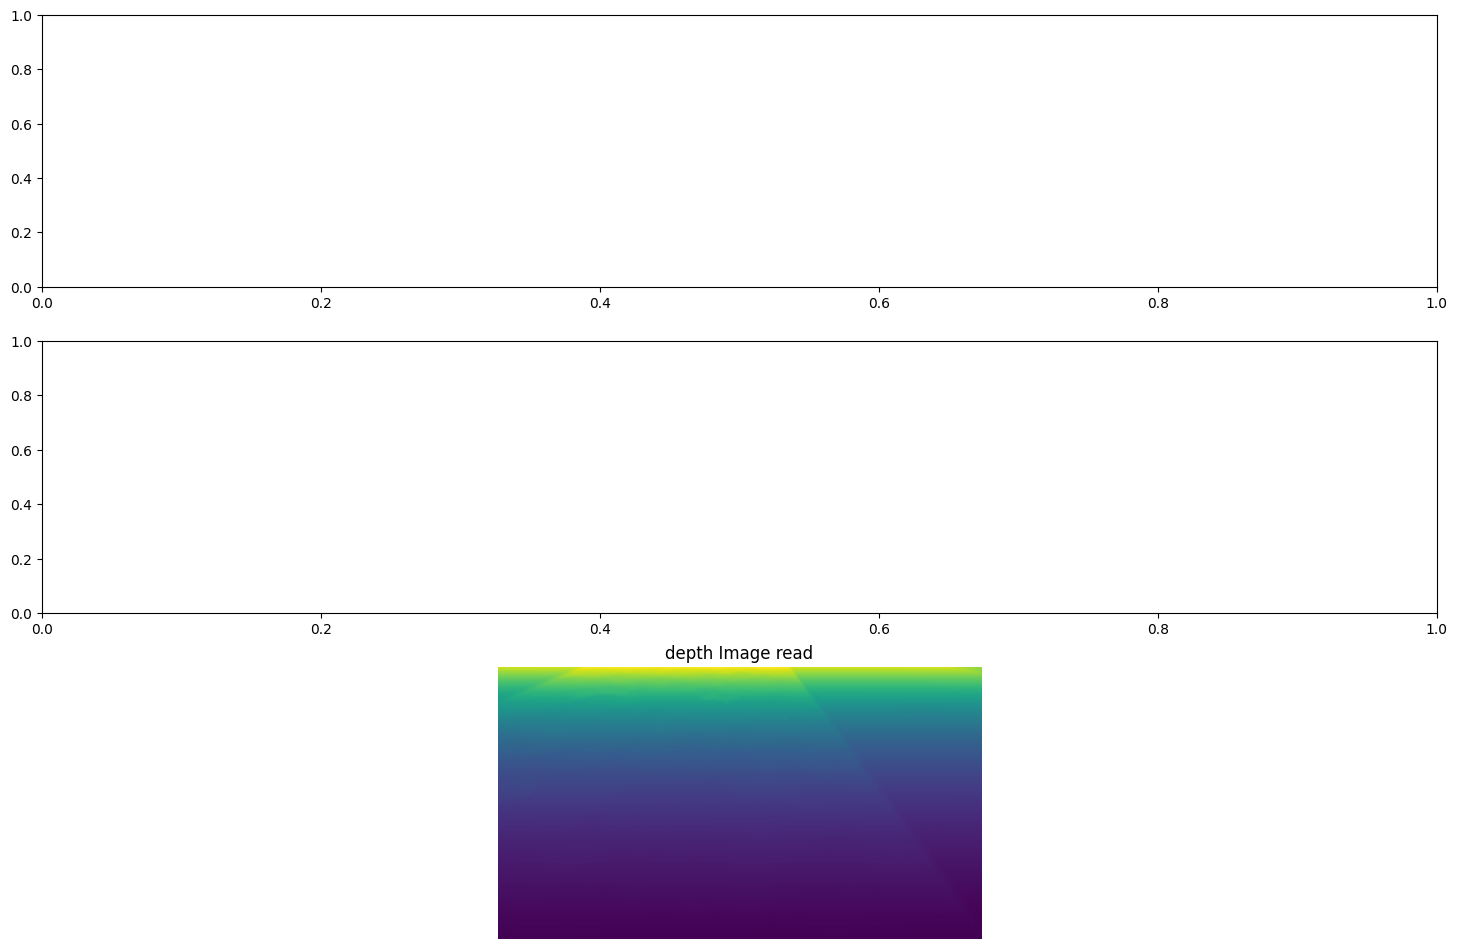

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


# 读取 depth,normal 文件
# depth_file = '/media/ljh/data/carla_pothole2/carla/training/roll0/base03/depth_left/23_849448266.jpeg'
# depth_data = cv2.imread(depth_file)[:,:,:]

# tmp = np.matmul(depth_data, np.array([65536, 256, 1]))
# tmp = np.array(tmp / tmp.max() * 256, dtype=np.int8)
# dp = np.array([tmp, tmp, tmp])
# # depth_data = dp.swapaxes(0,2).swapaxes(0,1)
# # dp = dp.swapaxes(1,2)
# depth_data = tmp
#
# # depth_data = cv2.cvtColor(dp, cv2.COLOR_BGR2RGB)
# print('depth.shape:', depth_data.shape, depth_data.dtype)
#
# disparity_file = '/media/ljh/data/carla_v2/testing/Tiled_V2/ClearNight/roll0/base05/disparity_left/63_449103532.npy'
# disparity_data = np.load(disparity_file)
# print('disparity.shape:', disparity_data.shape, disparity_data.dtype)
# print('disparity.min,max:', np.min(disparity_data), np.max(disparity_data))
# depth_data cal
# depth_data_cal = 0.5 * 640 / disparity_data
# print('depth_data_cal.min,max:', np.min(depth_data_cal), np.max(depth_data_cal))
# print('depth_data_cal.shape:', depth_data_cal.shape, depth_data_cal.dtype)
# depth_data read
depth_data_read = cv2.imread('/home/ljh/Desktop/Workspace/mmsegmentation/data/carla_v3/depth/training/8_395668236.png')
scales = np.array([65536.0, 256.0, 1.0])/(256**3 -1)*1000
dep_l = np.dot(depth_data_read, scales).astype(np.float32)
print('dep_l.shape:', dep_l.shape, dep_l.dtype)
print('depth_data_read.min,max:', np.min(dep_l), np.max(dep_l))

# rgb_file = '/media/ljh/data/carla_v2/testing/Tiled_V2/ClearNight/roll0/base05/rgb_front_left/63_449103532.png'
# rgb_data = cv2.imread(rgb_file)
# rgb_data = cv2.cvtColor(rgb_data, cv2.COLOR_BGR2RGB)
# print('rgb.shape:', rgb_data.shape, rgb_data.dtype)
#
# gt_file = '/media/ljh/data/carla_v2/testing/Tiled_V2/ClearNight/roll0/base05/gt_seg/63_449103532.png'
# gt_data = cv2.imread(gt_file)
# gt_data = cv2.cvtColor(gt_data, cv2.COLOR_BGR2RGB)
# print('gt.shape:', gt_data.shape, gt_data.dtype)
# 创建子图
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# axes[0].imshow(depth_data_cal)  # 如果是彩色图像，删除 'cmap' 参数
# axes[0].set_title('depth Image cal')
# axes[0].axis('off')
#
# axes[1].imshow(disparity_data, cmap='inferno')  # 如果是彩色图像，删除 'cmap' 参数
# axes[1].set_title('disparity Image')
# axes[1].axis('off')

axes[2].imshow(dep_l)  # 如果是彩色图像，删除 'cmap' 参数
axes[2].set_title('depth Image read')
axes[2].axis('off')

# axes[3].imshow(gt_data)  # 如果是彩色图像，删除 'cmap' 参数
# axes[3].set_title('gt Image')
# axes[3].axis('off')
# 显示图像
plt.show()

### 查看深度的范围  发现有问题，存在错误的深度文件，需要后续剔除  应该是贴图出现了空洞，暂时先不管

### 挑出3个子数据集深度异常的数据（正常在0-12米以内）
### 最终得出结论，存在贴图错误的数据，也存在含有悬崖以下区域的数据，导致深度分布不均匀，因此决定将这些数据放入数据集不能做删除，因为数量太多。但是在dataloader时因对每一个load进入网络的数据进行一次处理，初步想法是设定15米为阈值，先将所有真实深度图除以15米，再将其高于1以上的地方截断，当成1处理，就不会出现问题了。可视化部分也要做相同处理

In [ ]:
import os
import numpy as np
import cv2

# 数据集路径
dataset_path = "/media/ljh/data/carla_v2/testing/"

# 初始化全局最小值和最大值
global_min = np.inf
global_max = -np.inf

# 最大值和最小值对应的文件路径
min_file_path = ""
max_file_path = ""

# 深度超过15米的文件路径列表
over_15m_file_paths = []
# 深度超过15米的最大深度值列表
over_15m_max_depth = []

# 深度转换的比例
scales = np.array([65536.0, 256.0, 1.0])/(256**3 - 1)*1000

# 遍历所有的子文件夹
for scene_folder in os.listdir(dataset_path):
    scene_folder_path = os.path.join(dataset_path, scene_folder)
    for condition_folder in os.listdir(scene_folder_path):
        condition_folder_path = os.path.join(scene_folder_path, condition_folder)
        for roll_folder in os.listdir(condition_folder_path):
            roll_folder_path = os.path.join(condition_folder_path, roll_folder)
            for base_folder in os.listdir(roll_folder_path):
                base_folder_path = os.path.join(roll_folder_path, base_folder)
                depth_folder_path = os.path.join(base_folder_path, 'depth_left')
                if os.path.isdir(depth_folder_path):
                    # 遍历所有的.png文件
                    for file_name in os.listdir(depth_folder_path):
                        if file_name.endswith('.png'):
                            file_path = os.path.join(depth_folder_path, file_name)
                            # 加载.png文件
                            depth_data = cv2.imread(file_path)
                            # 计算真实深度
                            dep_l = np.dot(depth_data, scales).astype(np.float32)
                            # 计算当前深度图像的最小值和最大值
                            current_min = np.min(dep_l)
                            current_max = np.max(dep_l)
                            # 更新全局最小值和最大值
                            if current_min < global_min:
                                global_min = current_min
                                min_file_path = file_path
                            if current_max > global_max:
                                global_max = current_max
                                max_file_path = file_path
                            # 检查深度是否超过15米
                            if np.any(dep_l > 15):
                                over_15m_file_paths.append(file_path)
                                over_15m_max_depth.append(current_max)

print("最小值:", global_min, "来自文件:", min_file_path)
print("最大值:", global_max, "来自文件:", max_file_path)
print("深度超过15米的图像数量:", len(over_15m_file_paths))
print("深度超过15米的图像路径及其最大深度值:")
for file_path, max_depth in zip(over_15m_file_paths, over_15m_max_depth):
    print("文件路径:", file_path, "最大深度:", max_depth)

### 将数据集划分为更简单的结构

In [ ]:
import os
import shutil
import sys
import cv2


def reorganize_data(old_root_dir, new_root_dir, phase):
    # sub_dirs = ['disp_left', 'depth_left', 'normal_left', 'gt_seg', 'rgb_front_left']
    # new_sub_dirs = ['disparity', 'depth', 'normal', 'annotations', 'images']
    sub_dirs = ['disp_left']
    new_sub_dirs = ['disparity']
    for sub_dir, new_sub_dir in zip(sub_dirs, new_sub_dirs):
        for root, dirs, files in os.walk(os.path.join(old_root_dir, phase)):
            if root.endswith(sub_dir):
                for file in files:
                    old_file_path = os.path.join(root, file)
                    new_file_dir = os.path.join(new_root_dir, new_sub_dir, phase)
                    new_file_path = os.path.join(new_file_dir, file)
                    os.makedirs(new_file_dir, exist_ok=True)
                    shutil.copy2(old_file_path, new_file_path)
                    print(f'copied to {new_file_path} ')
old_root_dir = '/media/ljh/data/carla_v2'
new_root_dir = '/home/ljh/Desktop/Workspace/mmsegmentation/data/carla_v3'
phases = ['training', 'validation', 'testing']

for phase in phases:
    reorganize_data(old_root_dir, new_root_dir, phase)
    print(f'{phase} finished')
print('all finished!')

In [3]:
import cv2
import numpy as np
img =cv2.imread('/home/ljh/Desktop/Workspace/mmsegmentation/tools/kitti_benchmark/kitti_submit/um_road_000000.png', cv2.IMREAD_UNCHANGED)
# img = img/255

print('img.shape', img.shape)
# cv2.imshow('ori', img)
#
# cv2.waitKey()
# cv2.destroyAllWindows()

img.shape (720, 1280) uint16 25398


## kitti数据集划分

In [3]:
import os
import shutil
import random
from pathlib import Path

def move_files_to_validation(modality_dict, file_to_move):
    for modality, ext in modality_dict.items():
        source_file = file_to_move.replace('image_2', modality).replace('.png', ext)
        target_file = source_file.replace('training', 'validation')
        target_dir = os.path.dirname(target_file)

        # Create the target directory if it doesn't exist.
        Path(target_dir).mkdir(parents=True, exist_ok=True)

        # Move the file.
        shutil.move(source_file, target_file)
        print(f'successfully transform to {target_file}')

# change num of samples
def sample_files_for_validation(root_path):
    # Dictionary of all modalities and their respective file extensions
    modalities = {'sne': '.png', 'lidar_depth_2': '.png', 'disp_2': '.tiff'}
    val_rgb_path = os.path.join(root_path, 'validation', 'image_2')
    # Get a list of all the 'rgb_front_left' .png files
    all_files = [os.path.join(val_rgb_path, filename) for filename in os.listdir(val_rgb_path)]
    for selected_file in all_files:
        move_files_to_validation(modalities, selected_file)

root_path = '/home/ljh/Desktop/Workspace/custom_dataset/kitti/kitti_road'  # Update with your dataset path
sample_files_for_validation(root_path)
print('finished!')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ljh/Desktop/Workspace/custom_dataset/kitti/kitti_road/validation/sne/umm_000075.png'

In [3]:
import numpy as np
import cv2

disp = np.load('/home/ljh/Desktop/disp/000000_10.npy')
print(np.min(disp), np.max(disp), disp.dtype)
cv2.imshow('disp', disp.astype(np.uint8))

cv2.waitKey()
cv2.destroyAllWindows()

0.082259536 151.53262 float32


In [2]:
import os
import numpy as np
import cv2
# 假设utils模块包含必要的函数：get_DAG_filter, vector_normalization, MRF_optim
from utils import *

def get_cam_params_from_file(calib_file_path):
    with open(calib_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if 'P_rect_00:' in line:
                values = line.split(' ')[1:]
                fx, cx, fy, cy = float(values[0]), float(values[2]), float(values[5]), float(values[6])
                break
    return fx, fy, cx, cy

def depth2normal(depth_data, cam_fx, cam_fy, u0, v0):
    h, w = (375, 1242)

    u_map = np.ones((h, 1)) * np.arange(1, w + 1) - u0
    v_map = np.arange(1, h + 1).reshape(h, 1) * np.ones((1, w)) - v0
    Gu, Gv = get_DAG_filter(depth_data)
    est_nx = Gu * cam_fx
    est_ny = Gv * cam_fy
    est_nz = -(depth_data + v_map * Gv + u_map * Gu)
    est_normal = cv2.merge((est_nx, est_ny, est_nz))
    est_normal = vector_normalization(est_normal)
    est_normal = MRF_optim(depth_data, est_normal)
    n_vis = (1 - est_normal) / 2

    return n_vis

def process_folder(root_folder, calib_folder):
    scales = np.array([65536.0, 256.0, 1.0])/(256**3 -1)*1000
    for root, dirs, files in os.walk(root_folder):
        if 'completed_depth' in root:
            print("Processing files in: " + root)
            for file_name in files:
                if file_name.endswith('.png'):
                    depth_file_path = os.path.join(root, file_name)
                    calib_file_path = os.path.join(calib_folder, file_name.replace('.png', '.txt'))
                    cam_fx, cam_fy, u0, v0 = get_cam_params_from_file(calib_file_path)

                    depth_data = cv2.imread(depth_file_path, cv2.IMREAD_UNCHANGED)
                    n_vis = depth2normal(depth_data, cam_fx, cam_fy, u0, v0)
                    n_vis_65535 = np.round(n_vis * 65535).astype(np.uint16)

                    output_file_path = depth_file_path.replace('completed_depth', 'surface_normal')
                    output_dir = os.path.dirname(output_file_path)
                    os.makedirs(output_dir, exist_ok=True)
                    cv2.imwrite(output_file_path, n_vis_65535)
                    print("Processed file: " + depth_file_path)

root_folder = '/media/ljh/Kobe24/KITTI_Semantic/training/completed_depth'  # 设定为新的根目录路径
calib_folder = '/media/ljh/Kobe24/KITTI_Semantic/calib_cam_to_cam_training'  # 标定文件路径
process_folder(root_folder, calib_folder)
print('All finished!')


Processing files in: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000000.png


/home/ljh/Desktop/Workspace/depth-to-normal-translator/python/utils/myApis.py:59: RuntimeWarning: overflow encountered in power
  lap_power = np.power(base, -laplace_map)
/home/ljh/Desktop/Workspace/depth-to-normal-translator/python/utils/myApis.py:63: RuntimeWarning: invalid value encountered in divide
  return (lap_pow_l + eps * 0.5) / (eps + lap_pow_l + lap_pow_r), \
/home/ljh/Desktop/Workspace/depth-to-normal-translator/python/utils/myApis.py:64: RuntimeWarning: invalid value encountered in divide
  (lap_pow_r + eps * 0.5) / (eps + lap_pow_l + lap_pow_r)
/home/ljh/Desktop/Workspace/depth-to-normal-translator/python/utils/myApis.py:69: RuntimeWarning: invalid value encountered in divide
  return (lap_pow_u + eps / 2) / (eps + lap_pow_u + lap_pow_d), \
/home/ljh/Desktop/Workspace/depth-to-normal-translator/python/utils/myApis.py:70: RuntimeWarning: invalid value encountered in divide
  (lap_pow_d + eps / 2) / (eps + lap_pow_u + lap_pow_d)


Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000001.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000002.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000003.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000004.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000005.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000006.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000007.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000008.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000009.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000010.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/completed_depth/000011.png
Processed file: /media/ljh/Kobe24/KITTI_Semantic/training/complet

ValueError: operands could not be broadcast together with shapes (375,1242) (374,1238) 